# Linear Buckilng of Panel V2
use window kernel?
do cylinder buckling next?
can try sum of sinusoidal / periodic modes? That would probably be great for this problem (almost cheating if it works).

I believe the reason why it didn't work as well in the first approach to solve linear buckling is that the kernel functions may not
work well for eigenmode solving. Same thing happened with the PINN eigenvalue solver where it didn't work well and gave one half wave soln that doesn't satisfy BCs when I weakly enforced BCs. Needs shorter length scale but then regularization is failing with that. Instead, I can strongly enforce BCs with my kernel too (instead of weakly enforcing it like I am now).

Try using the sin^2 periodic kernel 
$$ k(x,x') = \sigma^2 \textrm{exp}(- \frac{2}{L^2} sin^2(\frac{\pi}{p} |x-x'|)) $$
Or try the bounded kernel idea I had:
$$ k(x,x') = \textrm{exp}(-\frac{(x-x')^2}{2L^2}) \cdot g(x) g(x') $$
where $g(x) = x(a-x)$. And do same for $y$ direction with $h(y) = y (b-y)$ as well.

In [14]:
# just comment this symbolic code out since don't want to run this each time I'm doing analysis

# first compute all the kernel derivatives
import sympy as sym

x = sym.Symbol('x')
xp = sym.Symbol('xp')
L = sym.Symbol('L')
a = sym.Symbol('a')

run_symbolic = False

if run_symbolic:

    kernel = sym.exp(-0.5 / L / L * (x - xp)**2) * x * (a-x) * xp * (a - xp)
    print(f"{kernel=}")

    lapl2_kernel = kernel.diff(x, x)
    lapl2_kernel = sym.simplify(lapl2_kernel)
    print(f"{lapl2_kernel=}")

    lapl4_kernel = kernel.diff(x, x, x, x)
    lapl4_kernel = sym.simplify(lapl4_kernel)
    print(f"{lapl4_kernel=}")

    lapl6_kernel = kernel.diff(x, x, x, x, xp, xp)
    lapl6_kernel = sym.simplify(lapl6_kernel)
    print(f"{lapl6_kernel=}")

    lapl8_kernel = kernel.diff(x, x, x, x, xp, xp, xp, xp)
    lapl8_kernel = sym.simplify(lapl8_kernel)
    print(f"{lapl8_kernel=}")

In [15]:
# panel linear static inputs
# buckling inputs
# ----------------

# aluminum plate material properties
E = 70e9; nu = 0.3; thick = 0.005
D = E * thick**3 / 12.0 / (1 - nu**2)
(a, b) = (3, 1)

axial = True
if axial:
    Nxx, Nxy, Nyy = (1e3, 0, 0)
else:
    Nxx, Nxy, Nyy = (0, 1e2, 0)

# choose kernel hyperparameters
Lx = 0.4; Ly = 0.4
# took out smaller lower length scale bc cause regularization to fail for now

# predict the buckling load factor (BLF)
pi = 3.14159
if axial:
    pred_buckling_load = pi**2 * D / b**2 * 4.0 
    pred_load_factor = pred_buckling_load / Nxx
    sigma = 0.5 * pred_load_factor
    print(f"{pred_load_factor=}")

pred_load_factor=31.633294000320518


type(x_train)=<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


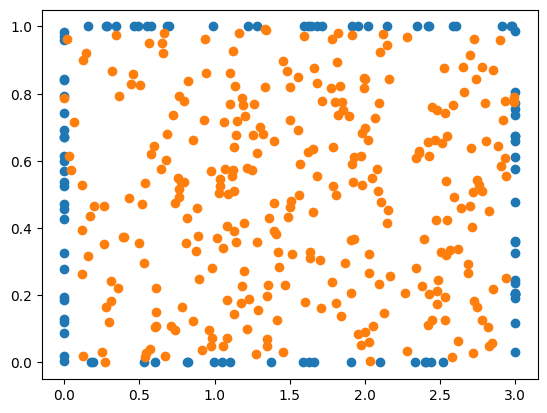

In [16]:
# compute the linear static analysis inputs and mesh domain of collocation pts
# ----------------------------------------------------------------------------
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# case = 'low'
# case = 'medium'
case = 'high'

if case == 'high':
    num_domain = 300
    num_bndry = 100
    num_test = 50
elif case == 'medium':
    num_domain = 40
    num_bndry = 10
    num_test = 50
elif case == 'low':
    num_domain = 10
    num_bndry = 5
    num_test = 5

num_interior = num_domain
DTYPE = tf.float32

# set the boundary of the panel
xmin = 0; xmax = a
ymin = 0; ymax = b

lb = tf.constant([xmin, ymin], dtype=DTYPE)
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# generate the collocation points on the interior
def gen_collocation_points(num_domain, minval, maxval):
    x_r = tf.random.uniform((num_domain,1), minval[0], maxval[0], dtype=DTYPE)
    y_r = tf.random.uniform((num_domain,1), minval[1], maxval[1], dtype=DTYPE)
    X_r = tf.concat([x_r, y_r], axis=1)
    # data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=0)
    # return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)
    return tf.Variable(X_r, dtype=DTYPE)

x_train = gen_collocation_points(num_domain, lb, ub)
x_test = gen_collocation_points(num_test, lb, ub)
print(f"{type(x_train)=}")

x = x_train[:,0:1]
y = x_train[:,1:2]

x2 = x_test[:,0:1]
y2 = x_test[:,1:2]

# generate boundary domain points
assert num_bndry % 2 == 0
N_b = int(num_bndry / 2)
x_b1 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
y_b1 = lb[1] + (ub[1] - lb[1]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b1 = tf.concat([x_b1, y_b1], axis=1)

# boundary data on x edges
y_b2 = tf.random.uniform((N_b,1), lb[1], ub[1], dtype=DTYPE)
x_b2 = lb[0] + (ub[0] - lb[0]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
# print(f"{x_b2=}")
X_b2 = tf.concat([x_b2, y_b2], axis=1)
# print(f"{X_b2=}")
# print(f"{x_b2=}")

x_bndry = tf.Variable(tf.concat([X_b1, X_b2], axis=0), dtype=DTYPE)

# plot the data to check
plt.scatter(x_bndry[:,0], x_bndry[:,1])
plt.scatter(x_train[:,0], x_train[:,1]) # only show 1000 of the points
plt.show()

In [17]:
# define all the derivatives here
# now it's non-stationary so uses x,xp not xbar
def d2_fact(x, xp, a, L):
    return -xp*(a - xp)*(2*L**4 + 2.0*L**2*(a - 2*x)*(x - xp) + 1.0*x*(L**2 - (x - xp)**2)*(a - x)) / L**4

def d4_fact(x, xp, a, L):
    return xp*(a - xp)*(12.0*L**6 - 12.0*L**4*(x - xp)**2 + 4*L**2*(3.0*L**2 - 1.0*(x - xp)**2)*(a - 2*x)* \
                        (x - xp) + x*(a - x)*(3.0*L**4 - 6.0*L**2*(x - xp)**2 + 1.0*(x - xp)**4))/L**8

def d6_fact(x, xp, a, L):
    return (-24.0*L**10 + L**8*(-24.0*xp*(a - xp) - 48.0*xp*(x - xp) + 48.0*(a - xp)*(x - xp) +\
            24.0*(x - xp)**2) + L**6*(-8*x*xp*(3.0*L**2 - 1.0*(x - xp)**2) + 24.0*x*xp*(a - xp)*(x - xp) +\
            16.0*x*xp*(x - xp)**2 + 8*x*(3.0*L**2 - 1.0*(x - xp)**2)*(a - xp) + 8*x*(3.0*L**2 - 1.0*(x - xp)**2)*(x - xp) -\
            16.0*x*(a - xp)*(x - xp)**2 - 12.0*xp*(L**2 - (x - xp)**2)*(a - xp) - 24.0*xp*(L**2 - (x - xp)**2)* \
            (x - xp) + 8*xp*(3.0*L**2 - 1.0*(x - xp)**2)*(a - x) - 24.0*xp*(a - x)*(a - xp)*(x - xp) - 16.0*xp*(a - x)* \
            (x - xp)**2 + 48.0*xp*(a - xp)*(x - xp)**2 + 24.0*(L**2 - (x - xp)**2)*(a - xp)*(x - xp) - 8*(3.0*L**2 -\
            1.0*(x - xp)**2)*(a - x)*(a - xp) - 8*(3.0*L**2 - 1.0*(x - xp)**2)*(a - x)*(x - xp) +\
            16.0*(a - x)*(a - xp)*(x - xp)**2) + L**4*(-12.0*x*xp*(L**2 - (x - xp)**2)*(a - x)*(a - xp) +\
            12.0*x*xp*(3.0*L**2 - 1.0*(x - xp)**2)*(a - xp)*(x - xp) + 8.0*x*xp*(3.0*L**2 - 1.0*(x - xp)**2)*(x - xp)**2 -\
            2*x*xp*(12.0*L**2 - 4.0*(x - xp)**2)*(a - x)*(x - xp) - 16.0*x*xp*(a - xp)*(x - xp)**3 - 8.0*x*(3.0*L**2 -\
            1.0*(x - xp)**2)*(a - xp)*(x - xp)**2 + 2*x*(12.0*L**2 - 4.0*(x - xp)**2)*(a - x)*(a - xp)*(x - xp) +\
            12.0*xp*(L**2 - (x - xp)**2)*(a - xp)*(x - xp)**2 - 12.0*xp*(3.0*L**2 - 1.0*(x - xp)**2)*(a - x)*(a - xp)*(x - xp) -\
            8.0*xp*(3.0*L**2 - 1.0*(x - xp)**2)*(a - x)*(x - xp)**2 + 16.0*xp*(a - x)*(a - xp)*(x - xp)**3 + 8.0*(3.0*L**2 -\
            1.0*(x - xp)**2)*(a - x)*(a - xp)*(x - xp)**2) + L**2*x*(a - x)*(3.0*L**4 - 6.0*L**2*(x - xp)**2 + 1.0*(x - xp)**4)* \
            (-1.0*xp*(a - xp) - 2.0*xp*(x - xp) + 2.0*(a - xp)*(x - xp)) + L**2*(-2*L**2*x*(a - x)*(3.0*L**4 - 6.0*L**2*(x - xp)**2 + \
            1.0*(x - xp)**4) - 4.0*x*xp*(3.0*L**2 - 1.0*(x - xp)**2)*(a - xp)*(x - xp)**3 + 2.0*x*xp*(12.0*L**2 -\
            4.0*(x - xp)**2)*(a - x)*(a - xp)*(x - xp)**2 + 4.0*xp*(3.0*L**2 - 1.0*(x - xp)**2)*(a - x)*(a - xp)*(x - xp)**3) +\
            1.0*x*xp*(a - x)*(a - xp)*(x - xp)**2*(3.0*L**4 - 6.0*L**2*(x - xp)**2 + 1.0*(x - xp)**4))/L**12

def d8_fact(x, xp, a, L):
    return (432.0*L**12 + 240.0*L**10*a**2 - 300.0*L**10*a*x - 300.0*L**10*a*xp - 2484.0*L**10*x**2 + 5568.0*L**10*x*xp -\
        2484.0*L**10*xp**2 - 1140.0*L**8*a**2*x**2 + 2385.0*L**8*a**2*x*xp - 1140.0*L**8*a**2*xp**2 + 1320.0*L**8*a*x**3 -\
        1425.0*L**8*a*x**2*xp - 1425.0*L**8*a*x*xp**2 + 1320.0*L**8*a*xp**3 + 1644.0*L**8*x**4 - 9216.0*L**8*x**3*xp +\
        15249.0*L**8*x**2*xp**2 - 9216.0*L**8*x*xp**3 + 1644.0*L**8*xp**4 + 660.0*L**6*a**2*x**4 - 3060.0*L**6*a**2*x**3*xp +\
        4800.0*L**6*a**2*x**2*xp**2 - 3060.0*L**6*a**2*x*xp**3 + 660.0*L**6*a**2*xp**4 - 720.0*L**6*a*x**5 + 2580.0*L**6*a*x**4*xp -\
        1860.0*L**6*a*x**3*xp**2 - 1860.0*L**6*a*x**2*xp**3 + 2580.0*L**6*a*x*xp**4 - 720.0*L**6*a*xp**5 - 276.0*L**6*x**6 +\
        3096.0*L**6*x**5*xp - 10320.0*L**6*x**4*xp**2 + 15000.0*L**6*x**3*xp**3 - 10320.0*L**6*x**2*xp**4 + 3096.0*L**6*x*xp**5 -\
        276.0*L**6*xp**6 - 100.0*L**4*a**2*x**6 + 810.0*L**4*a**2*x**5*xp - 2340.0*L**4*a**2*x**4*xp**2 + 3260.0*L**4*a**2*x**3*xp**3 -\
        2340.0*L**4*a**2*x**2*xp**4 + 810.0*L**4*a**2*x*xp**5 - 100.0*L**4*a**2*xp**6 + 104.0*L**4*a*x**7 - 730.0*L**4*a*x**6*xp +\
        1566.0*L**4*a*x**5*xp**2 - 940.0*L**4*a*x**4*xp**3 - 940.0*L**4*a*x**3*xp**4 + 1566.0*L**4*a*x**2*xp**5 - 730.0*L**4*a*x*xp**6 +\
        104.0*L**4*a*xp**7 + 12.0*L**4*x**8 - 304.0*L**4*x**7*xp + 1794.0*L**4*x**6*xp**2 - 4632.0*L**4*x**5*xp**3 + \
        6260.0*L**4*x**4*xp**4 - 4632.0*L**4*x**3*xp**5 + 1794.0*L**4*x**2*xp**6 - 304.0*L**4*x*xp**7 + 12.0*L**4*xp**8 +\
        4.0*L**2*a**2*x**8 - 60.0*L**2*a**2*x**7*xp + 280.0*L**2*a**2*x**6*xp**2 - 644.0*L**2*a**2*x**5*xp**3 + 840.0*L**2*a**2*x**4*xp**4 - \
        644.0*L**2*a**2*x**3*xp**5 + 280.0*L**2*a**2*x**2*xp**6 - 60.0*L**2*a**2*x*xp**7 + 4.0*L**2*a**2*xp**8 - 4.0*L**2*a*x**9 + \
        56.0*L**2*a*x**8*xp - 220.0*L**2*a*x**7*xp**2 + 364.0*L**2*a*x**6*xp**3 - 196.0*L**2*a*x**5*xp**4 - 196.0*L**2*a*x**4*xp**5 + \
        364.0*L**2*a*x**3*xp**6 - 220.0*L**2*a*x**2*xp**7 + 56.0*L**2*a*x*xp**8 - 4.0*L**2*a*xp**9 + 8.0*L**2*x**9*xp - \
        92.0*L**2*x**8*xp**2 + 392.0*L**2*x**7*xp**3 - 868.0*L**2*x**6*xp**4 + 1120.0*L**2*x**5*xp**5 - 868.0*L**2*x**4*xp**6 + \
        392.0*L**2*x**3*xp**7 - 92.0*L**2*x**2*xp**8 + 8.0*L**2*x*xp**9 + 1.0*a**2*x**9*xp - 8.0*a**2*x**8*xp**2 + \
        28.0*a**2*x**7*xp**3 - 56.0*a**2*x**6*xp**4 + 70.0*a**2*x**5*xp**5 - 56.0*a**2*x**4*xp**6 + 28.0*a**2*x**3*xp**7 - \
        8.0*a**2*x**2*xp**8 + 1.0*a**2*x*xp**9 - 1.0*a*x**10*xp + 7.0*a*x**9*xp**2 - 20.0*a*x**8*xp**3 + 28.0*a*x**7*xp**4 - \
        14.0*a*x**6*xp**5 - 14.0*a*x**5*xp**6 + 28.0*a*x**4*xp**7 - 20.0*a*x**3*xp**8 + 7.0*a*x**2*xp**9 - \
        1.0*a*x*xp**10 + 1.0*x**10*xp**2 - 8.0*x**9*xp**3 + 28.0*x**8*xp**4 - 56.0*x**7*xp**5 + 70.0*x**6*xp**6 - 56.0*x**5*xp**7 + \
        28.0*x**4*xp**8 - 8.0*x**3*xp**9 + 1.0*x**2*xp**10)/L**16


In [18]:
# now define the main kernels and derivative kernels for 2d case

L_tf = tf.constant(np.array([Lx, Ly]), dtype=DTYPE)
def g(x,a): # 1d level set
    return x * (a-x)

def kernel2d_tf(x, xp):
    # x input is N x 1 x 2 array, xp is 1 x M x 2 array
    # xbar is then an N x M x 2 shape array
    # print(f"{x=} {L_tf=}")
    xbar = (x - xp) / L_tf
    x1 = x[:,:,0]
    x2 = x[:,:,1]
    x1p = xp[:,:,0]
    x2p = xp[:,:,1]
    # output is N x M matrix of kernel matrix
    return tf.exp(-0.5 * tf.reduce_sum(tf.pow(xbar, 2.0), axis=-1)) * g(x1,a) * g(x1p,a) * g(x2,b) * g(x2p,b)

def dx2_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    Lx = L_tf[0]; Ly = L_tf[1]
    x1 = x[:,:,0]
    x2 = x[:,:,1]
    x1p = xp[:,:,0]
    x2p = xp[:,:,1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    # TODO : shear or general case later (just axial now)
    return K * (d2_fact(x1, x1p, a, Lx))

def doubledx2_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    Lx = L_tf[0]; Ly = L_tf[1]

    x1 = x[:,:,0]
    x2 = x[:,:,1]
    x1p = xp[:,:,0]
    x2p = xp[:,:,1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    # TODO : shear or general case later (just axial now)
    return K * (d4_fact(x1, x1p, a, Lx))

def kernel2d_bilapl_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    Lx = L_tf[0]; Ly = L_tf[1]
    x1 = x[:,:,0]
    x2 = x[:,:,1]
    x1p = xp[:,:,0]
    x2p = xp[:,:,1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    return K * (d4_fact(x1, x1p, a,Lx) + 2.0 * d2_fact(x1, x1p, a,Lx) * d2_fact(x2, x2p, b, Ly) + d4_fact(x2, x2p, b, Ly))

def kernel2d_double_bilapl_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    Lx = L_tf[0]; Ly = L_tf[1]
    x1 = x[:,:,0]
    x2 = x[:,:,1]
    x1p = xp[:,:,0]
    x2p = xp[:,:,1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    return K * (d8_fact(x1, x1p, a, Lx) + \
                4.0 * d6_fact(x1, x1p, a, Lx) * d2_fact(x2, x2p, b, Ly) + \
                6.0 * d4_fact(x1, x1p, a, Lx) * d4_fact(x2, x2p, b, Ly) + \
                4.0 * d2_fact(x1, x1p, a, Lx) * d6_fact(x2, x2p, b, Ly) + \
                d8_fact(x2, x2p, b, Ly))

def dx2_bilapl_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    Lx = L_tf[0]; Ly = L_tf[1]
    x1 = x[:,:,0]
    x2 = x[:,:,1]
    x1p = xp[:,:,0]
    x2p = xp[:,:,1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    # TODO : shear or general case later (just axial now)
    return K * \
        (d6_fact(x1, x1p, a, Lx) +\
         2.0 * d4_fact(x1, x1p, a, Lx) * d2_fact(x2, x2p, b, Ly) + \
         d2_fact(x1, x1p, a, Lx) * d4_fact(x2, x2p, b, Ly) )

num_interior=300 num_all=400
done with full matrix assembly..
min_eigval=-1298698.2 max_eigval=9815833.0
done with eigenvalues solve
double check eivals again--
min_eigval=-1298600.0 max_eigval=9815931.0


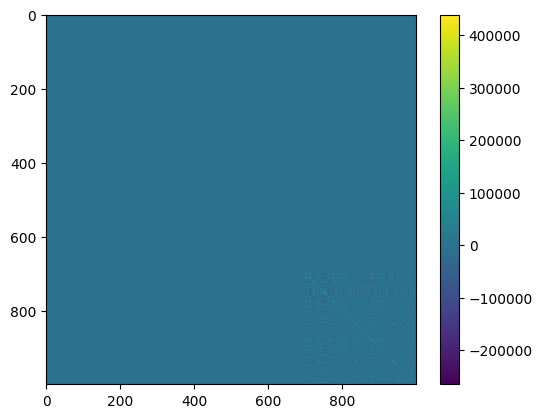

In [19]:
# compute the block matrix Sigma = [cov(w_int, w_int), cov(w_int, w_bndry), cov(w_int, nabla^4 w_int),
#                                   cov(w_bndry, w_int), cov(w_bndry, w_bndry), cov(w_bndry, nabla^4 w_bndry),
#                                   cov(nabla^4 w_int, w_int), cov(nabla^4 w_int, w_bndry), cov(nabla^4 w_int, nabla^4 w_int) ]
# not a function of theta..
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

n_block = 3 * num_interior + num_bndry
x_all = tf.concat([x_train, x_bndry], axis=0)
num_all = num_interior + num_bndry

# 11 - interior+bndry self-covariance
x_all_L = tf.expand_dims(x_all, axis=1)
x_all_R = tf.expand_dims(x_all, axis=0)
K11 = tf.constant(kernel2d_tf(x_all_L, x_all_R), dtype=DTYPE)

x_interior_L = tf.expand_dims(x_train, axis=1)
x_interior_R = tf.expand_dims(x_train, axis=0)

# 12 - w with Gw
K12 = tf.constant(dx2_kernel_tf(x_all_L, x_interior_R))
# 13 - w with nabla^4 w
K13 = tf.constant(kernel2d_bilapl_tf(x_all_L, x_interior_R))
# 22 - Gw with Gw
K22 = tf.constant(doubledx2_kernel_tf(x_interior_L, x_interior_R))
# 23 - Gw with nabla^4 w
K23 = tf.constant(dx2_bilapl_kernel_tf(x_interior_L, x_interior_R))
# 33 - nabla^4 w with nabla^4 w
K33 = tf.constant(kernel2d_double_bilapl_tf(x_interior_L, x_interior_R))

print(f"{num_interior=} {num_all=}")
# print(f"{K11.shape=} {K12.shape=} {K22.shape=}")
# print(f"{K13.shape=} {K23.shape=} {K33.shape=}")

# assemble full covariance matrix
_row1 = tf.constant(tf.concat([K11, K12, K13], axis=1))
_row2 = tf.constant(tf.concat([tf.transpose(K12), K22, K23], axis=1))
_row3 = tf.constant(tf.concat([tf.transpose(K13), tf.transpose(K23), K33], axis=1))
Kblock_prereg = tf.concat([_row1, _row2, _row3], axis=0)

print(f"done with full matrix assembly..")

# apply robust regularization w.r.t. the max eigenvalue, namely we add epsilon * I term to matrix
# where epsilon = alpha * lambda_max
alpha = 1e-5
eigvals = np.linalg.eigvalsh(Kblock_prereg)
min_eigval = np.min(eigvals)
max_eigval = np.max(eigvals)
print(f"{min_eigval=} {max_eigval=}")
eps = alpha * max_eigval

print("done with eigenvalues solve")

Kblock = tf.constant(Kblock_prereg + eps * tf.eye(n_block), dtype=DTYPE)

# double check eigvals again
print("double check eivals again--")
eigvals = np.linalg.eigvalsh(Kblock)
min_eigval = np.min(eigvals)
max_eigval = np.max(eigvals)
print(f"{min_eigval=} {max_eigval=}")

# show the matrix image to see if positive definite roughly
plt.imshow(Kblock)
plt.colorbar()

In [20]:
# define GP vectors and factor cov matrix into LU
# -----------------------------------------------

# setup lambda as trainable parameter too
# lam = tf.Variable(pred_load_factor, trainable=True, dtype=DTYPE)

K_lu = tf.linalg.lu(Kblock)

w_ext = tf.zeros(shape=(num_bndry,1), dtype=DTYPE)
# now theta includes the w int points and Gw interior points and also lam
# theta_arr = tf.zeros(shape=(num_domain * 2 + 1,1), dtype=DTYPE)
# theta_arr = np.random.rand(2 * num_domain + 1, 1)
# theta_arr = tf.ones(shape=(num_domain * 2 + 1, 1), dtype=DTYPE)

theta_arr = np.zeros(shape=(num_domain*2 + 1,1))
theta_arr[-1,0] = pred_load_factor # set lam init

# pick one of points nearest the middle a/2, b/2
cent_dist = (x_train[:,0] - a/2.0)**2 + (x_train[:,1] - b/2.0)**2
ind = tf.argmin(cent_dist)
theta_arr[ind,0] = 1e-5 # set init value of w somewhere so not 0 norm

# [5,0] = 1.0 # best to choose some middle point as the only nonzero part?
theta = tf.Variable(theta_arr, trainable=True, dtype=DTYPE)

# print(f"{w_ext.shape=}")
# nabla4_w = 
# nabla4_w2 = tf.reshape(nabla4_w, shape=(num_domain,1))
# print(f"{nabla4_w2.shape=}")

# _temp = tf.concat([w_ext, nabla4_w2], axis=0)
# fixed_vec = tf.constant(_temp, dtype=DTYPE)

In [21]:
num_epochs = 5000 # 5000
learning_rate = 1e-5 # can be much higher here?
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for epoch in range(num_epochs):
    # record the loss gradient
    with tf.GradientTape(persistent=True) as tape:
        # construct full GP f vector
        w_int = theta[:num_interior]
        Gw = theta[num_interior:-1]
        lam = theta[-1]
        # lam = pred_load_factor # try constant for a minute
        # lam = 8.0
        nabla4_w = -lam / D * Nxx * Gw
        w_full = tf.concat([w_int, w_ext, Gw, nabla4_w], axis=0)

        # normalize w_full by w_norm to prevent trivial soln in buckling analysis
        w_norm = tf.linalg.norm(w_int)
        w_full_hat = w_full / w_norm

        # print(f"{w_full=}")
        ans = tf.linalg.lu_solve(*K_lu, rhs=w_full_hat)
        # print(f"{ans=}")

        loss = tf.tensordot(tf.transpose(w_full_hat), ans, axes=1)
        loss *= 1e3

        # add norm regularization term to prevent trivial soln (since buckling trivial w = 0 soln is technically a soln, but not one we care about)
        # this didn't work very well => just focuses on this term not PDE solving
        # loss += (w_norm - 1)**2 # * 1e4
        # # loss *= 1e3 # *= D

    loss_gradient = tape.gradient(loss, theta)
    # print(f"{loss_gradient=}")

    # could change to Gauss-newton algorithm here instead.. would prob be better

    # gradient descent with adam optimizer
    optimizer.apply_gradients(
        [(loss_gradient, theta)]
    )
    del tape

    loss_val = loss.numpy()[0,0]
    eigval = lam.numpy()[0]
    print(f"{epoch=}\t{loss_val=}\t{eigval=}")

# print(f"{theta=}")

epoch=0	loss_val=10.284248	eigval=31.633293
epoch=1	loss_val=13128.284	eigval=31.633293
epoch=2	loss_val=-4654.013	eigval=31.633286
epoch=3	loss_val=-8623.003	eigval=31.633282
epoch=4	loss_val=-15722.415	eigval=31.633282
epoch=5	loss_val=-32655.398	eigval=31.633286
epoch=6	loss_val=-85800.67	eigval=31.633291
epoch=7	loss_val=-310734.56	eigval=31.633299
epoch=8	loss_val=-1764879.1	eigval=31.633305
epoch=9	loss_val=-81693704.0	eigval=31.63331
epoch=10	loss_val=-5781180.0	eigval=31.633316
epoch=11	loss_val=-1681394.1	eigval=31.633322
epoch=12	loss_val=-911309.9	eigval=31.633326
epoch=13	loss_val=-622917.94	eigval=31.63333
epoch=14	loss_val=-479102.94	eigval=31.633333
epoch=15	loss_val=-395107.97	eigval=31.633337
epoch=16	loss_val=-340898.16	eigval=31.63334
epoch=17	loss_val=-303438.94	eigval=31.633343
epoch=18	loss_val=-276246.3	eigval=31.633345
epoch=19	loss_val=-255758.06	eigval=31.633347
epoch=20	loss_val=-239871.44	eigval=31.633348
epoch=21	loss_val=-227271.31	eigval=31.63335
epoch=22

KeyboardInterrupt: 

In [22]:
# predict the values at a grid of points (a mesh) so we can view predicted contour of the solution
# using the mean interpolated from trained values
import numpy as np

n = 100
ngrid = n * n
_xgrid = np.linspace(0.0, a, n)
_ygrid = np.linspace(0.0, b, n)
X, Y = np.meshgrid(_xgrid, _ygrid)
xgrid = np.reshape(X, newshape=(ngrid,1))
ygrid = np.reshape(Y, newshape=(ngrid,1))
x_grid = np.concatenate([xgrid, ygrid], axis=1)

# old non-vectorized way
# K_train = np.array([[kernel2d(x_all[i,:], x_all[j,:]) for j in range(num_all)] for i in range(num_all)])
# K_cross = np.array([[kernel2d(x_grid[i,:], x_all[j,:]) for j in range(num_all)] for i in range(ngrid)])

# vectorized way like 100x faster
K_train = kernel2d_tf(x_all_L, x_all_R)
x_grid_L = tf.expand_dims(tf.constant(x_grid, dtype=DTYPE), axis=1)
K_cross = kernel2d_tf(x_grid_L, x_all_R)

max_eigval = np.max(np.linalg.eigvalsh(K_train))
W_grid = K_cross @ np.linalg.solve(K_train + 1e-5 * max_eigval * np.eye(num_all), w_full[:num_all,:])
W = np.reshape(W_grid, newshape=(n, n))

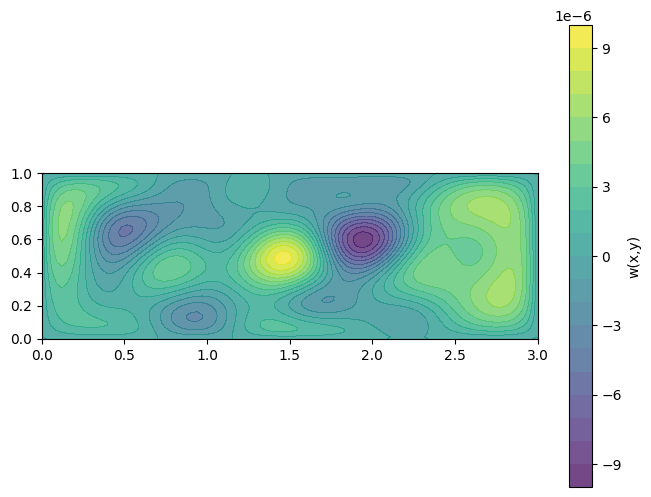

In [23]:
import matplotlib.pyplot as plt
# now plot the predicted solution contour
plt.figure(figsize=(8, 6))
colors = plt.contourf(X, Y, W, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
plt.gca().set_aspect('equal')
plt.colorbar(colors, label="w(x,y)")  # Colorbar for reference

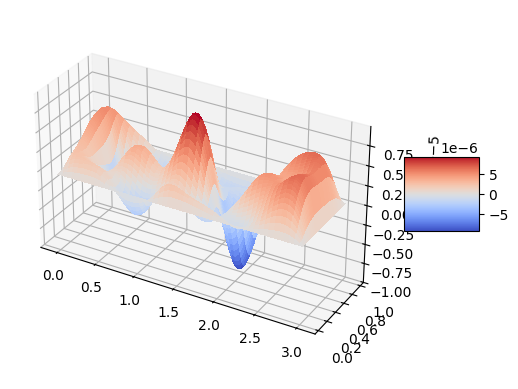

In [24]:
import matplotlib.pyplot as plt
from matplotlib import cm
# now plot the predicted solution surface in 3d
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=1)
ax.set_aspect('equalxy')
plt.show()